In [1]:
!wget https://raw.githubusercontent.com/pacifikus/itmo_dl_course/refs/heads/master/HW/hw_1/cybersequrity.csv

--2025-12-14 17:33:58--  https://raw.githubusercontent.com/pacifikus/itmo_dl_course/refs/heads/master/HW/hw_1/cybersequrity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 641962 (627K) [text/plain]
Saving to: ‘cybersequrity.csv.3’

cybersequrity.csv.3 100%[===================>] 626.92K  --.-KB/s    in 0.04s   

2025-12-14 17:33:58 (14.1 MB/s) - ‘cybersequrity.csv.3’ saved [641962/641962]



In [2]:
import pandas as pd
import numpy as np
import random
import os
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [3]:
seed = 42

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(seed)

Random seed set as 42


In [4]:
df = pd.read_csv('cybersequrity.csv')

In [5]:
df.head()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [6]:
df['Class'].value_counts()

,count
Class,
1,5096
0,4904


In [7]:
target = df['Class']
X = df.iloc[:, :-1]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, target, test_size=0.4, random_state=seed, stratify=target
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=seed, stratify=y_tmp
)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [10]:
y_val.values

array([1, 0, 1, ..., 0, 1, 1])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [12]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
from torch import nn
from torch import optim
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [14]:
class BaselineModel(nn.Module):
    def __init__(self, num_labels, input_size, hidden_size, n_linear_layers=3, activation=nn.ReLU):
        super(BaselineModel, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), activation()]

        for i in range(n_linear_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation())

        layers.append(nn.Linear(hidden_size, num_labels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        y_pred = torch.sigmoid(self.layers(x))
        return y_pred

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
model = BaselineModel(1, X_train.shape[1], 128, 3, nn.ReLU)
model.to(device)

BaselineModel(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [17]:
def train_model(model, num_epochs=100, eval_freq=10):
  train_loss_history, eval_loss_history = [], []
  train_f1_history, eval_f1_history = [], []
  global_step = 0

  model.train()
  for epoch in tqdm(range(num_epochs)):
      for batch_X, target in train_dataloader:
        optimizer.zero_grad()
        log_probs = model(batch_X.to(device))
        loss = loss_function(log_probs, target.to(device))
        loss.backward()
        optimizer.step()

        preds = (log_probs >= 0.5).int().cpu().tolist()
        f1 = f1_score(preds, target.cpu().numpy().tolist())

        train_loss_history.append((global_step, loss.item()))
        train_f1_history.append((global_step, f1))

        if global_step % eval_freq == 0:
              val_loss, val_f1 = evaluate(model)
              eval_loss_history.append((global_step, val_loss))
              eval_f1_history.append((global_step, val_f1))
              model.train()

        if global_step % 250 == 0:
              clear_output(True)

              plt.figure(figsize=(15, 5))

              plt.subplot(121)
              plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
              if len(eval_loss_history):
                  plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
              plt.legend()

              plt.subplot(122)
              plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
              if len(eval_f1_history):
                  plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
              plt.legend()
              plt.show()
        global_step += 1

  return model

In [18]:
@torch.no_grad()
def evaluate(model, mode='eval'):
    model.eval()

    dataloader = val_dataloader if mode == 'eval' else test_dataloader

    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in dataloader:
      log_probs = model(batch_X.to(device))
      loss = loss_function(log_probs, target.to(device))
      num = log_probs.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      preds_list += (log_probs >= 0.5).int().cpu().tolist()
      targets_list += target.cpu().numpy().tolist()

    f1 = f1_score(preds_list, targets_list)

    return loss_epoch / num_epoch, f1

In [19]:
loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

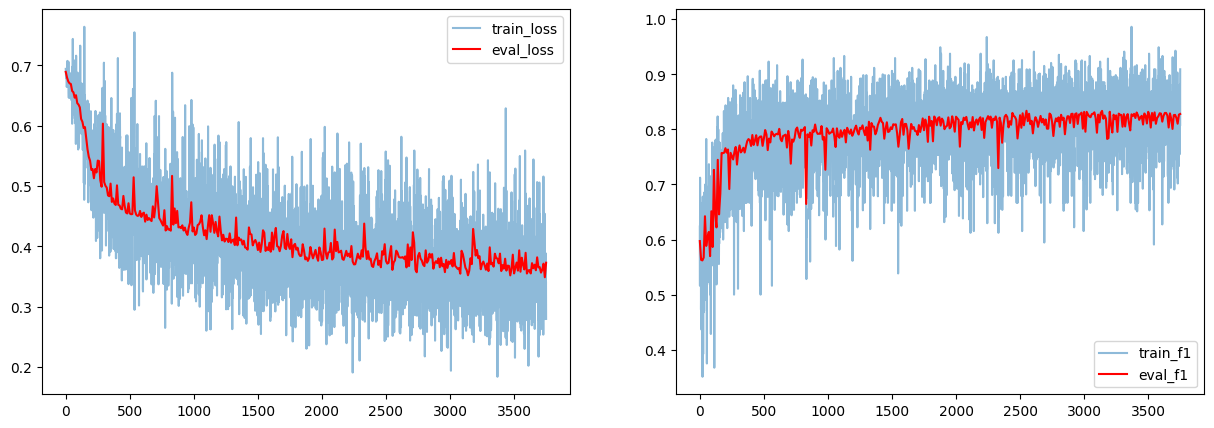

In [20]:
model = train_model(model, num_epochs=40)

In [21]:
evaluate(model, mode='test')

(0.3890581293106079, 0.817773339990015)

In [22]:
from sklearn.metrics import classification_report

def report(model):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_X, target in test_dataloader:
            batch_X = batch_X.to(device)
            target = target.to(device)

            probs = model(batch_X)
            preds = (probs >= 0.5).int()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    print(classification_report(all_targets, all_preds))

report(model)

              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82       981
         1.0       0.83      0.80      0.82      1019

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [23]:
class BetterModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=(256, 128, 64),
                 dropout_p=0.2, use_bn=True, activation=nn.ReLU):
        super().__init__()

        layers = []
        prev = input_size

        for hs in hidden_sizes:
            layers.append(nn.Linear(prev, hs))
            if use_bn:
                layers.append(nn.BatchNorm1d(hs))
            layers.append(activation())
            if dropout_p and dropout_p > 0:
                layers.append(nn.Dropout(dropout_p))
            prev = hs

        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

In [24]:
from sklearn.metrics import f1_score
import numpy as np
import torch

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    losses, preds_all, targets_all = [], [], []

    for Xb, yb in dataloader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        probs = model(Xb)
        loss = loss_fn(probs, yb)
        loss.backward()
        optimizer.step()

        losses.append(loss.item() * Xb.size(0))
        preds_all += (probs >= 0.5).int().detach().cpu().view(-1).tolist()
        targets_all += yb.detach().cpu().view(-1).int().tolist()

    avg_loss = sum(losses) / len(dataloader.dataset)
    f1 = f1_score(targets_all, preds_all)
    return avg_loss, f1


@torch.no_grad()
def eval_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    losses, preds_all, targets_all = [], [], []

    for Xb, yb in dataloader:
        Xb, yb = Xb.to(device), yb.to(device)

        probs = model(Xb)
        loss = loss_fn(probs, yb)

        losses.append(loss.item() * Xb.size(0))
        preds_all += (probs >= 0.5).int().cpu().view(-1).tolist()
        targets_all += yb.cpu().view(-1).int().tolist()

    avg_loss = sum(losses) / len(dataloader.dataset)
    f1 = f1_score(targets_all, preds_all)
    return avg_loss, f1

In [25]:
import copy

def fit_model(model, train_loader, val_loader, optimizer, loss_fn, device,
              epochs=50, patience=8):
    best_state = None
    best_val_f1 = -1
    wait = 0

    history = {"train_loss": [], "train_f1": [], "val_loss": [], "val_f1": []}

    for epoch in range(1, epochs+1):
        tr_loss, tr_f1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        va_loss, va_f1 = eval_one_epoch(model, val_loader, loss_fn, device)

        history["train_loss"].append(tr_loss)
        history["train_f1"].append(tr_f1)
        history["val_loss"].append(va_loss)
        history["val_f1"].append(va_f1)

        if va_f1 > best_val_f1:
            best_val_f1 = va_f1
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            break

    model.load_state_dict(best_state)
    return model, history, best_val_f1

In [26]:
def plot_history(hist, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(hist["train_loss"], label="train loss")
    axes[0].plot(hist["val_loss"], label="val loss")
    axes[0].set_title(f"Loss: {title}")
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")
    axes[0].legend()

    axes[1].plot(hist["train_f1"], label="train f1")
    axes[1].plot(hist["val_f1"], label="val f1")
    axes[1].set_title(f"F1: {title}")
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("f1")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

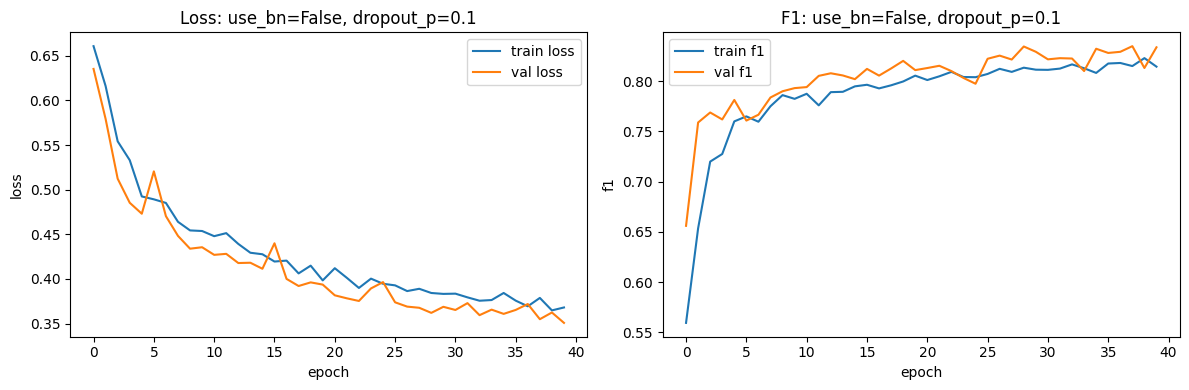

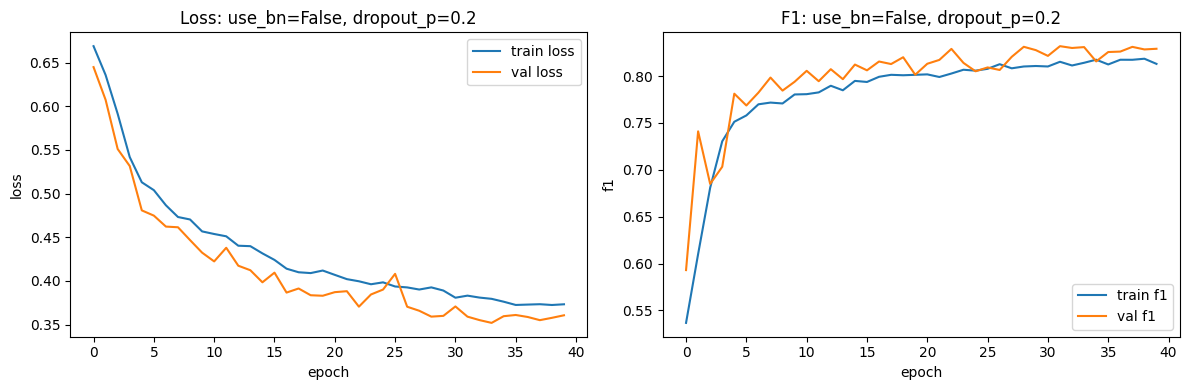

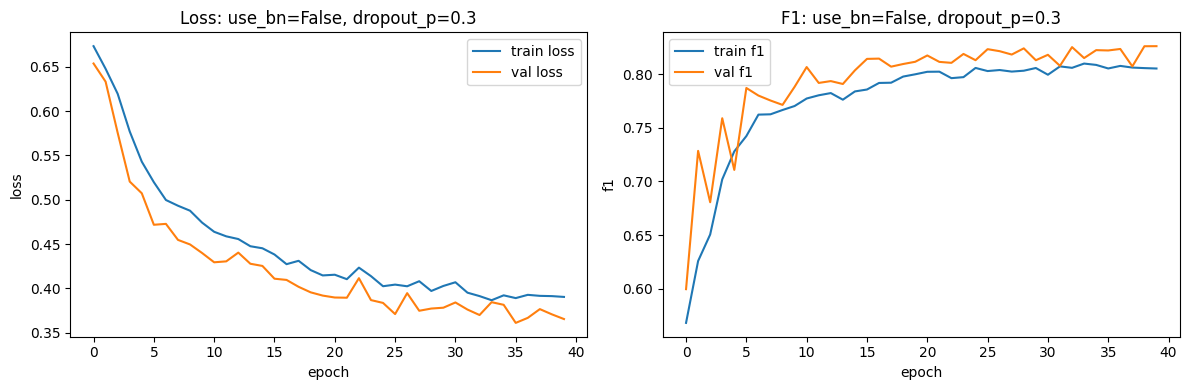

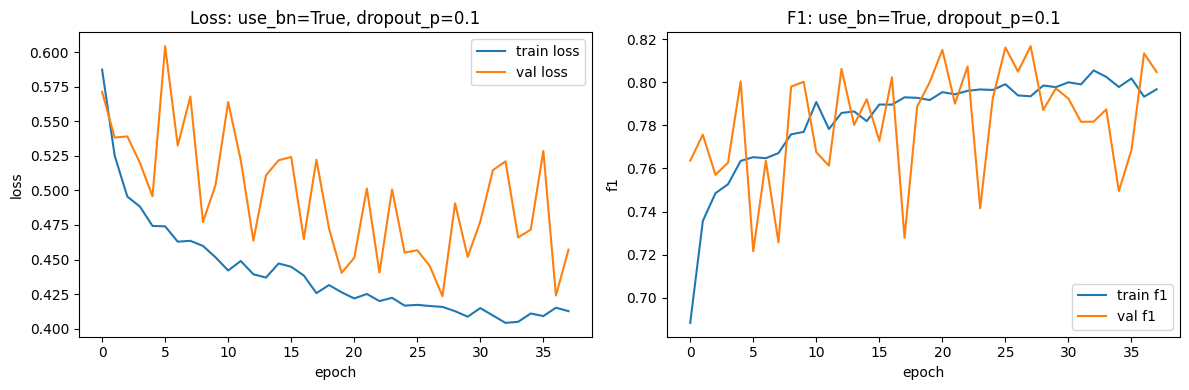

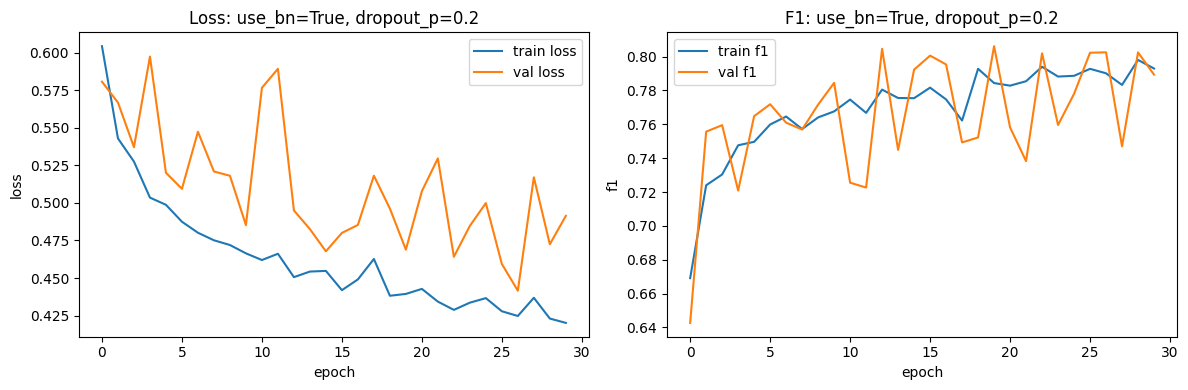

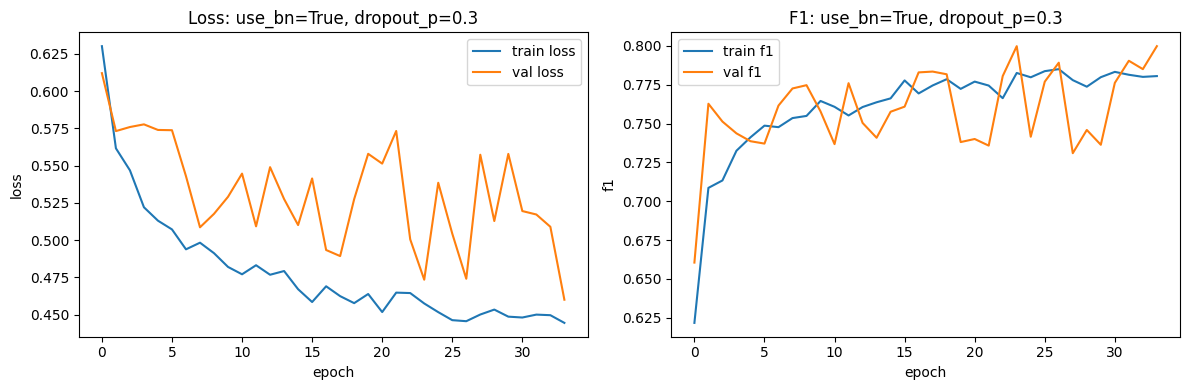

,use_bn,dropout_p,best_val_f1,final_train_f1,final_val_f1,model
0,False,0.1,0.834711,0.814342,0.833588,BetterModel(\n (net): Sequential(\n (0): L...
1,False,0.2,0.831924,0.813039,0.829146,BetterModel(\n (net): Sequential(\n (0): L...
2,False,0.3,0.826324,0.805470,0.826324,BetterModel(\n (net): Sequential(\n (0): L...
3,True,0.1,0.816683,0.796688,0.804653,BetterModel(\n (net): Sequential(\n (0): L...
4,True,0.2,0.806157,0.792944,0.789351,BetterModel(\n (net): Sequential(\n (0): L...
5,True,0.3,0.799811,0.780553,0.799808,BetterModel(\n (net): Sequential(\n (0): L...


In [27]:
loss_fn = nn.BCELoss()

configs = [
    {"use_bn": False,  "dropout_p": 0.1},
    {"use_bn": False,  "dropout_p": 0.2},
    {"use_bn": False,  "dropout_p": 0.3},
    {"use_bn": True,  "dropout_p": 0.1},
    {"use_bn": True,  "dropout_p": 0.2},
    {"use_bn": True,  "dropout_p": 0.3},
]

results = []

for cfg in configs:
    model = BetterModel(
        input_size=X_train.shape[1],
        hidden_sizes=(256, 128, 64),
        dropout_p=cfg["dropout_p"],
        use_bn=cfg["use_bn"],
        activation=nn.ReLU
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    model, hist, best_val_f1 = fit_model(
        model, train_dataloader, val_dataloader,
        optimizer, loss_fn, device,
        epochs=40, patience=10
    )


    title = f"use_bn={cfg['use_bn']}, dropout_p={cfg['dropout_p']}"
    plot_history(hist, title=title)

    results.append({
        "use_bn": cfg["use_bn"],
        "dropout_p": cfg["dropout_p"],
        "best_val_f1": best_val_f1,
        "final_train_f1": hist["train_f1"][-1],
        "final_val_f1": hist["val_f1"][-1],
        "model": model
    })

df_res = pd.DataFrame(results).sort_values("best_val_f1", ascending=False)
df_res

In [28]:
best_model = df_res.iloc[0]['model']
report(best_model)

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       981
         1.0       0.87      0.77      0.82      1019

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000




## Подготовка данных
Исходный датасет был предварительно обработан: данные были разделены на обучающую, валидационную и тестовую выборки в пропорции 60/20/20 со стратификацией по целевой переменной Class. Это позволило сохранить одинаковое распределение классов во всех подвыборках и избежать смещения оценки качества модели.
Для ускорения сходимости и стабилизации обучения входные признаки были стандартизированы с использованием StandardScaler, обученного исключительно на обучающей выборке, что исключило утечку информации из валидационной и тестовой выборок.

## Базовая модель
В качестве базовой модели был реализован многослойный персептрон (MLP) с несколькими линейными слоями и нелинейными функциями активации. Данная модель позволила установить начальный уровень качества и выявить признаки переобучения, выраженные в расхождении метрик на обучающей и валидационной выборках.

## Улучшение архитектуры
Для повышения качества модели была использована архитектура с тремя скрытыми слоями и сужающейся размерностью. Такое количество слоёв представляет собой компромисс между выразительной способностью модели и устойчивостью обучения на табличных данных.
В архитектуру были добавлены слои BatchNorm1d и Dropout. BatchNorm размещался после линейных слоёв и перед функциями активации, что способствовало стабилизации распределений предактиваций и ускорению обучения. Dropout применялся после функций активации и использовался в качестве регуляризатора.

## Анализ влияния BatchNorm и Dropout
Эксперименты показали, что BatchNorm в данной задаче не приводит к существенному росту итогового качества модели. Это объясняется тем, что входные признаки уже были стандартизированы с помощью StandardScaler, а используемая архитектура не является глубокой. Кроме того, при относительно небольшом размере батча статистики BatchNorm могут быть шумными, что приводит к колебаниям метрик на валидационной выборке.
Dropout, в свою очередь, продемонстрировал более выраженный положительный эффект. Его использование позволило снизить переобучение и сделать динамику метрик на валидационной выборке более стабильной. Наиболее сбалансированным значением параметра p оказался диапазон 0.1, при котором удаётся уменьшить переобучение без значительной потери полезного сигнала.